# Применение сети Хопфилда в машинном обучении

### Цель работы

Изучение принципов работы сети Хопфилда, реализация модели и проведение экспериментов, демонстрирующих возможность её применения в задачах машинного обучения

---

### Постановка задачи

Восстановление зашумленных изображений
Датасет: MNIST (подмножество из 100 изображений цифр 0-9 размером `15x15` пикселей, предварительно уменьшенных из оригинальных `28x28` пикселей).

Задание:
1. Ознакомиться с теоретическими основами сети Хопфилда, её архитектурой и принципами работы.
2. Загрузить и предобработать изображения MNIST, уменьшив их до `15x15` пикселей и бинаризовав (-1 - фон, 1 - пиксель).
3. Реализовать сеть Хопфилда и обучить её на 10 различных образах цифр.
4. Добавить случайный шум (заменяя 20-30% пикселей на противоположные значения) и проверить способность сети к восстановлению образов.
5. Оценить точность восстановления по метрике доли совпадающих пикселей.

---

### Результат выполнения работы

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from typing import Tuple
from sklearn.metrics import accuracy_score, confusion_matrix

Производится загрузка изображений рукописных цифр от 0 до 9 (датасет MNIST). Всего для обучения было подготовлено **14 изображений** (паттернов). Для цифр 1, 4, 7 и 9 было решено взять дополнительно по одному примеру, так как вариации написания этих цифр сильно различаются.

Тестовый набор содержит **10 000** изображений цифр.

Все изображения сразу векторизуются и сохраняются в `numpy.array` и к каждой выборке подтягивается вектор таргетов. 

In [2]:
train_images = []
train_target = []

test_images = []
test_target = []

for i in range(10):
    path = f'./datasets/MNIST/mnist_train/{i}'
    
    for file in os.listdir(path):
        if file.endswith('.png'):
            img_path = os.path.join(path, file)        
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            vector = img.flatten()
            train_images.append(vector)
            train_target.append(i)

train_images = np.array(train_images)
# train_target = np.array(train_target)

for i in range(10):
    path = f'./datasets//MNIST/mnist_all/valid/{i}'
    
    for file in os.listdir(path):
        if file.endswith('.png'):
            img_path = os.path.join(path, file)        
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            vector = img.flatten()
            test_images.append(vector)
            test_target.append(i)

test_images = np.array(test_images)
# test_target = np.array(test_target)

print(f'Размер train вектора - {train_images.shape}')
print(f'Размер train вектора таргетов - {len(train_target)}\n')

print(f'Размер test вектора - {test_images.shape}')
print(f'Размер test вектора таргетов - {len(test_target)}')

Размер train вектора - (14, 784)
Размер train вектора таргетов - 14

Размер test вектора - (10000, 784)
Размер test вектора таргетов - 10000


Вызов атрибута `shape` показывает, что тренировочный вектор состоит из 14 векторов (14 изображений) размером 784 элемента (28x28 пикселей). Тестовый вектор соответственно из 10000 изображений такого же размера.

Для визуализации векторизованных изображений реализуется функция, которая выводит 16 случайных изображений для анализа и знакомства с данными.

Сразу осуществляется вывод исходных загруженных данных.

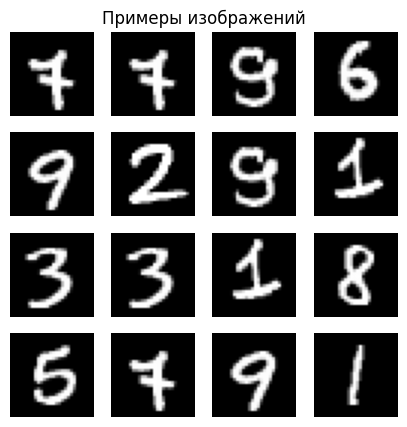

In [3]:
def show_images(images: np.ndarray, shape: Tuple[int, int] = (28, 28)) -> None:
    plt.figure(figsize=(5, 5))
    plt.title('Примеры изображений')
    plt.axis('off')
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        idx = random.randint(0, images.shape[0]-1)
        plt.imshow(images[idx].reshape(shape), cmap='gray')
        plt.axis('off')
    
    plt.show()

show_images(train_images)

Далее необходимо уменьшить размер изображений до 15x15 пикселей. Для этого изображения обратно конвертируются в матричный вид и сжимаются. Следующим шагом производится бинаризация изображений (отображение в 2 цветах: белом и черном), порог разделения - 130. То есть все пиксели со значением больше 130 принимают значение +1, остальные -1.

После произведенных манипуляций визуализируется часть преобразованных данных.

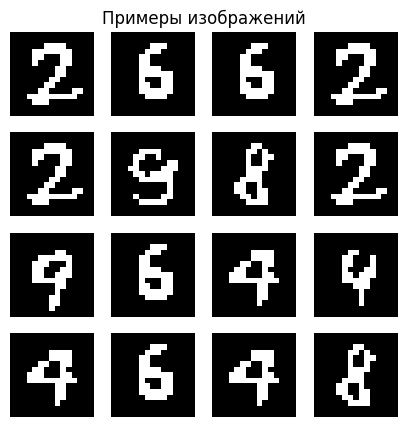

In [4]:
def get_binary_img(matrix: np.ndarray, final_size: Tuple[int, int]) -> np.ndarray:
    binary_images = []
    for img_vector in matrix:
        # преобразование вектора изображения к матричному виду
        orig_size = int((img_vector.shape[0])**0.5)
        img = img_vector.reshape(orig_size, orig_size)
        
        # сжатие изображения
        img_resized = cv2.resize(img, final_size, interpolation=cv2.INTER_AREA)
        
        # бинаризация изображения
        img_binary = np.where(img_resized >= 130, 1, -1)

        # обратное преобразование
        binary_images.append(img_binary.flatten())
    
    return np.array(binary_images)

shape = (15, 15)
train_data = get_binary_img(train_images, shape)
test_data = get_binary_img(test_images, shape)
show_images(train_data, shape)

Реализуется класс нейронной сети Хопфилда.

При инициализации объекта класса задаются 4 параметра: 
- `num_neurons`: кол-во нейронов (равно длинам векторов входных изображений)
- `W`: матрица весов, которая сразу зануляется для дальнейшего заполнения
- `train_matrix` - матрица тренировочных данных
- `train_targets` - вектор целевых переменных

Обучение сети производится на ортогональных паттернах, так обучение методом Хебба не справлялось с восстановлением зашумленных изображений (алгоритм обучения методом Хебба был оставлен в закомментированном виде, чтобы можно было проверить его работу при необходимости).

Восстановление изображений производится обычным перемножением матрицы весов на входной вектор с последующей прогонкой результата через функцию `sign()` (нули заменяются на 1, т.к. сеть Хопфилда работает только с 1 и -1).

Для получения вектора весов (при необходимости) реализуется геттер `get_weights`.

In [5]:
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.W = np.zeros((num_neurons, num_neurons))
        self.train_matrix = None
        self.train_targets = None

    # def train(self, matrix):
    #     for p in matrix:
    #         self.W += np.outer(p, p)
    #     np.fill_diagonal(self.W, 0)
    #     self.W /= len(matrix)

    def train(self, matrix: np.ndarray, targets: list[int]) -> None:
        self.train_matrix = matrix
        self.train_targets = targets
        
        ortho_matrix = []
        for p in matrix:
            p = p.astype(float)
            for op in ortho_matrix:
                p -= np.dot(op, p) * op
            p_norm = np.linalg.norm(p)
            if p_norm > 10**(-10):
                p /= p_norm
            ortho_matrix.append(p)

        for p in ortho_matrix:
            self.W += np.outer(p, p)
        
        np.fill_diagonal(self.W, 0)
        self.W /= len(matrix)

    def recall(self, img: np.ndarray, max_iter: int = 10) -> np.ndarray:
        s = np.array(img)
        for i in range(max_iter):
            s_new = np.sign(np.dot(self.W, s))
            s_new[s_new == 0] = 1
            if np.array_equal(s, s_new):
                break
            s = s_new

        # определение метки класса предсказанной цифры 
        if self.train_matrix is not None:
            distances = [np.sum((s - train_p)**2) for train_p in self.train_matrix]
            closest_idx = np.argmin(distances)
            label = self.train_targets[closest_idx]
        else:
            label = -1
        
        return s, label

    def get_weights(self) -> np.ndarray:
        return self.W

Следующим шагом производится создание модели и ее обучение на подготовленных данных.

In [6]:
n_neuron = train_data.shape[1]
hopfield_model = HopfieldNetwork(n_neuron)
hopfield_model.train(train_data, train_target)

Модель успешно обучена. Для проверки корректности работы реализуется функция для зашумления изображений (замены случайных пикселей на обратные).

In [7]:
def add_noise(img: np.ndarray, noise_level: float = 0.2) -> np.ndarray:
    noisy = img.copy()
    noisy_cnt = int(noise_level * len(noisy))
    indices = np.random.choice(len(noisy), noisy_cnt, replace=False)
    noisy[indices] = -noisy[indices]
    return noisy

К одному из исходных изображений добавляется 20% шум и проверяется работа модели. 

In [8]:
original_pattern = train_data[4]
noisy_pattern = add_noise(original_pattern, noise_level=0.2)
recalled_pattern = hopfield_model.recall(noisy_pattern, 10)[0]

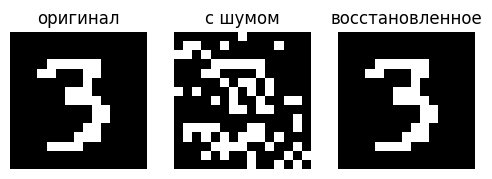

In [9]:
plt.figure(figsize=(6, 2))

plt.subplot(1, 3, 1)
plt.imshow(original_pattern.reshape(shape), cmap='gray')
plt.title('оригинал')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_pattern.reshape(shape), cmap='gray')
plt.title('с шумом')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(recalled_pattern.reshape(shape), cmap='gray')
plt.title('восстановленное')
plt.axis('off')

plt.show()

Далее модель проверяется на тестовых изображениях. Для начала тестовые изображения просто визуализируются.

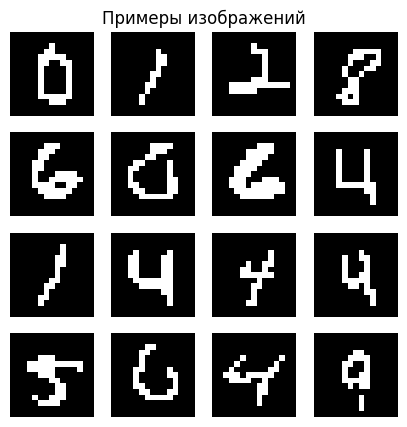

In [10]:
show_images(test_data, shape)

Работа модели проверяется на 6 тестовых изображениях.

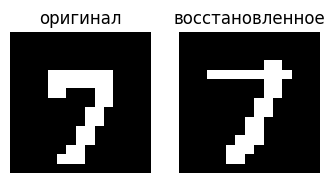

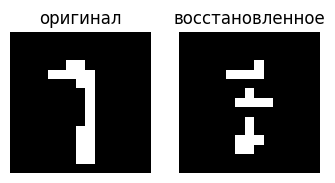

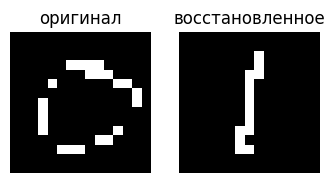

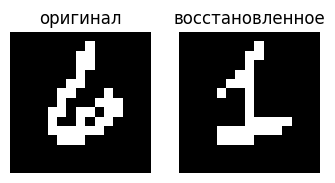

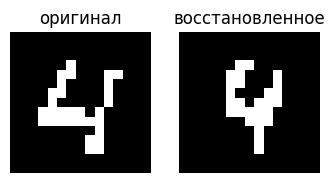

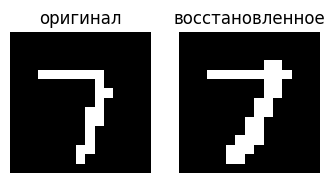

In [11]:
for i in range(6):
    idx = random.randint(0, 10000 - 1)
    test_img = test_data[idx]
    pred_img = hopfield_model.recall(test_img, 10)[0]
    
    plt.figure(figsize=(4, 2))
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_img.reshape(shape), cmap='gray')
    plt.title('оригинал')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_img.reshape(shape), cmap='gray')
    plt.title('восстановленное')
    plt.axis('off')
    
    plt.show()

Далее производится тестирование способности модели классифицировать тестовые изображения. Тестовый массив состоит из 10000 изображений, которые модель ранее не видела. Получается вектор предсказаний модели для этих данных. 

In [ ]:
hopfield_pred = []

for i in range(test_data.shape[0]):
    hopfield_pred.append(hopfield_model.recall(test_data[i], 10)[1])

Проверяется корректность вектора предсказаний. Для этого выводятся все уникальные значения и кол-во всех значений.

In [ ]:
print(f'уникальные значения - {set(hopfield_pred)}')
print(f'кол-во значений - {len(hopfield_pred)}')

Все корректно, поэтому производится подсчет метрики качества. В качестве метрики качества была выбрана точность (accuracy).

In [ ]:
hopfield_accuracy = accuracy_score(test_target, hopfield_pred)
print(f'Точность - {round(hopfield_accuracy * 100, 2)}%')

Точность модели составляет 41.32%, что указывает на её низкую эффективность для классификации цифр MNIST. Сеть Хопфилда плохо справляется с данной задачей из-за схожести цифр и ограниченной ёмкости ассоциативной памяти.

Для того, чтобы понять какие изображения модель путает, выводится матрица неточностей (`confusion_matrix`).

In [ ]:
cm = confusion_matrix(test_target, hopfield_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',)
plt.ylabel('истинные значения')
plt.xlabel('предсказанные значения')
plt.title('Матрица неточностей (сonfusion matrix)', fontsize=14);

По матрице неточностей можно сделать вывод, что модель показывает хорошие результаты в распознавании цифры 1 (1042 правильных предсказания), однако иногда путает её с 7 и 3. 

Цифра 2 распознается очень часто распознается моделью как 1, это связано с тем, что после сжатия изображений, они обе эти цифры очень похожи друг на друга. Но тем не менее 2 путается и с другими цифрами, хоть и чуть реже.

С цифрами 3, 4, 6, 7, 9 модель справляется неплохо. В большинстве случаев она правильно их распознает.

Цифры 0, 5, и 8 модель распознает довольно плохо. Очень часто она путает их с другими цифрами.

Такой низкий показатель качества модели связан с тем, что, во-первых, модель способна запоминать ограниченное кол-во паттернов, из-за чего она не может определить особые "вариации" изображений. Во-вторых, из-за того, что изображения предварительно были сжаты до 15x15 пикселей изображения стали больше похожи друг на друга, из-за чего, соответственно, различать их стало труднее (даже для человека).

---

### Выводы

В ходе выполнения работы были изучены принципы работы сети Хопфилда и успешно была реализована ассоциативная память на основе данной сети, способная восстанавливать зашумлённые изображения цифр и определять похожие паттерны на других изображениях из датасета MNIST.

Реализованная модель успешно восстанавливает зашумлённые на 20% изображения цифр MNIST, подтвердив свою эффективность для ассоциативной памяти на малых наборах данных.

Но в задаче классификации модель показала довольно низкое качество. Лучше всего она распознаёт цифру 1, цифру 2 ошибочно относит к классу 1. С остальными цифрами показатели достаточно неточные. Основное ограничение модели - это довольно малое число образов, которые она может запомнить и затем успешно восстановить. Также важную роль сыграло сжатие изображений до 15×15 пикселей, из-за чего были потеряны ключевые детали образов. 

Для задач, требующих высокой точности, данная архитектура не подходит. 